In [1]:
#load libraries

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from collections import OrderedDict

In [2]:
#load dataset

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', 
                            train=True, 
                            transform=transform,
                            download=True
                           )

test_dataset = torchvision.datasets.FashionMNIST(root='./data', 
                            train=False, 
                            transform=transform,
                           )

Processing...
Done!


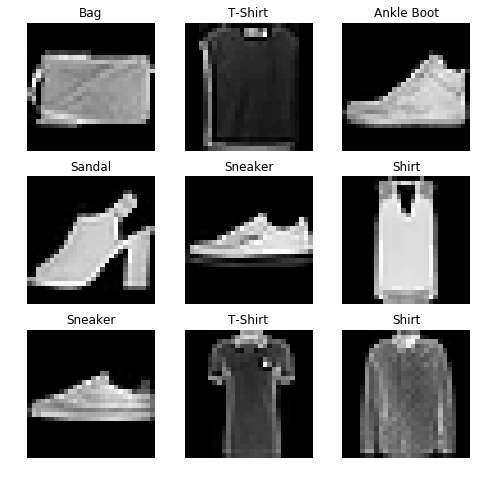

In [5]:
#show preview of data

import matplotlib.pyplot as plt
import numpy as np

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 3;
rows = 3;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[int(train_dataset[img_xy][1].numpy())])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [7]:
# Check for class imbalance in training data to accurately reflect accuracy over entire model
import pandas as pd
df_train_data = pd.read_csv("../data/fashion-mnist_train.csv")

df_train_data['label'].value_counts()


9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [8]:
# setting all the parameters
batch_size = 100
n_iters = 12000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.001

In [10]:
# create the dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,            
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [11]:
# model architecture

model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(784,500)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(500,300)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(p=0.3)),
    ('fc3', nn.Linear(300,100)),
    ('relu3', nn.ReLU()),
    ('dropout3', nn.Dropout(p=0.2)),
    ('fc4', nn.Linear(100,10)),
    ('output', nn.LogSoftmax(dim = 1))
]))

In [12]:
# create criterion and optimizer:
criterion = nn.CrossEntropyLoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:

# Implement a function for the validation pass
def validation(model, test_loader, criterion):
    valid_loss = 0
    accuracy = 0
    for inputs, labels in test_loader:
        
        inputs, labels = inputs.view(-1, 784).to('cpu'), labels.to('cpu')

        output = model.forward(inputs)
        valid_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [ ]:
print_every = 500
steps = 0

model.to('cpu')
for e in range(num_epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(train_loader):
        
        steps += 1
        inputs, labels = inputs.view(-1, 784).to('cpu'), labels.to('cpu')
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            model.eval()

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                valid_loss, accuracy = validation(model, test_loader, criterion)

            print("Epoch: {}/{}.. ".format(e+1, num_epochs),
                    "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                    "Valid Loss: {:.3f}.. ".format(valid_loss/len(test_loader)),
                    "Valid Accuracy: {:.3f}".format(accuracy/len(test_loader)))

            running_loss = 0

            # Make sure training is back on
            model.train()

In [15]:
# save model checkpoint
model.class_to_name = labels_map

checkpoint = {'epochs': num_epochs,
              'input_size': 784,
              'output_size': 10,
              'optimizer_state_dict': optimizer.state_dict(),
              'model_state_dict': model.state_dict(),
              'class_to_idx': model.class_to_name }

torch.save(checkpoint, 'checkpoint.pth')            

In [15]:
# TODO: Do validation on the test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.view(-1, 784).to('cpu'), labels.to('cpu')
        outputs = model.forward(images)
        ps = torch.exp(outputs)
        _, predicted = torch.max(ps, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 89 %


In [20]:
from sklearn.metrics import confusion_matrix

# confusion matrix
for images, labels in test_loader:
        images, labels = images.view(-1, 784).to('cpu'), labels.to('cpu')
        outputs = model.forward(images)
        ps = torch.exp(outputs)
        _, predicted = torch.max(ps, 1)
        conf_matrix += confusion_matrix(y_true=labels.numpy(), y_pred=predicted.numpy())

In [22]:
print(conf_matrix)

array([[854,   0,  27,  16,   4,   3,  90,   0,   6,   0],
       [  3, 976,   3,  11,   5,   0,   2,   0,   0,   0],
       [ 11,   2, 833,   6,  79,   0,  67,   0,   2,   0],
       [ 27,   8,  24, 885,  33,   0,  18,   0,   5,   0],
       [  1,   1,  90,  27, 815,   2,  61,   0,   3,   0],
       [  0,   0,   0,   1,   0, 963,   0,  27,   0,   9],
       [119,   1,  87,  20,  63,   0, 699,   0,  11,   0],
       [  0,   0,   0,   0,   0,   8,   0, 984,   0,   8],
       [  7,   0,   2,   3,   3,   4,   2,   5, 974,   0],
       [  0,   0,   0,   0,   0,  17,   1,  53,   0, 929]], dtype=int64)

In [26]:
for i in range(0,10):
    tp = conf_matrix[i,i]
    fp = sum(conf_matrix[:, i])-conf_matrix[i,i]
    fn = sum(conf_matrix[i, :])-conf_matrix[i,i]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn) 
    print("Class {}: Precision = {:.2f}, Recall = {:.2f}".format(labels_map[(i)],precision,recall))

Class T-Shirt: Precision = 0.84, Recall = 0.85
Class Trouser: Precision = 0.99, Recall = 0.98
Class Pullover: Precision = 0.78, Recall = 0.83
Class Dress: Precision = 0.91, Recall = 0.89
Class Coat: Precision = 0.81, Recall = 0.81
Class Sandal: Precision = 0.97, Recall = 0.96
Class Shirt: Precision = 0.74, Recall = 0.70
Class Sneaker: Precision = 0.92, Recall = 0.98
Class Bag: Precision = 0.97, Recall = 0.97
Class Ankle Boot: Precision = 0.98, Recall = 0.93
